In [10]:
import pandas as pd

In [11]:
train=pd.read_csv('train_format2.csv')

In [12]:
print(train.shape)
print(train.head())

(7030723, 6)
   user_id  age_range  gender  merchant_id  label  \
0    34176        6.0     0.0          944     -1   
1    34176        6.0     0.0          412     -1   
2    34176        6.0     0.0         1945     -1   
3    34176        6.0     0.0         4752     -1   
4    34176        6.0     0.0          643     -1   

                                        activity_log  
0                            408895:1505:7370:1107:0  
1  17235:1604:4396:0818:0#954723:1604:4396:0818:0...  
2  231901:662:2758:0818:0#231901:662:2758:0818:0#...  
3                             174142:821:6938:1027:0  
4                             716371:1505:968:1024:3  


In [24]:
# 过滤掉-1
train_valid = train[train['label'].isin([0, 1])].copy()# 原因：train_valid是train的切片，直接赋值会触发CopyWarning +copy()
# 计算比例
print(train_valid['label'].value_counts(normalize=True) * 100)

label
0    93.884936
1     6.115064
Name: proportion, dtype: float64


In [25]:
def parse_log(log_str):
    # 1. 如果log_str是空值，返回(0, 0, 0)
    if pd.isna(log_str):
        return 0, 0, 0
    
    # 2. 按'#'分割字符串，得到行为列表
    items = log_str.split('#')
    
    # 3. 总行为数 = 列表长度
    total = len(items)
    
    # 4. 初始化计数器
    purchase = 0
    click = 0
    
    # 5. 遍历每个行为
    for item in items:
        # 6. 按':'分割，得到5个部分
        parts = item.split(':')
        
        # 7. 确保分割正确（有5个部分）
        if len(parts) == 5:
            # 8. 取第5个元素（索引4），转成整数
            action = int(parts[4])
            
            # 9. 判断行为类型：2是购买，0是点击
            if action == 2:
                purchase += 1
            elif action == 0:
                click += 1
    
    # 10. 返回三个计数
    return total, purchase, click

In [26]:
# 用iloc按位置取（推荐）
test_log = train_valid.iloc[0]['activity_log']
print("原始:", test_log[:100])

原始: 757713:821:6268:1110:0#757713:821:6268:1110:0#757713:821:6268:1110:0#718096:1142:6268:1031:3#757713:


In [27]:
result = parse_log(test_log)
print("结果:", result)

结果: (39, 1, 36)


In [17]:
## 39次行为里，1次购买+36次点击=37次，还有2次可能是收藏/加购（action=1或3）

In [28]:
# 对每一行应用parse_log函数
results = train_valid['activity_log'].apply(parse_log)

# 拆分成三列
train_valid['activity_count'] = results.apply(lambda x: x[0])# train_valid['activity_count']新建一列，存总次数  lambda x: x[0]输入x，返回x的第0个元素
train_valid['purchase_count'] = results.apply(lambda x: x[1])
train_valid['click_count'] = results.apply(lambda x: x[2])

# 查看结果
print(train_valid[['user_id', 'activity_count', 'purchase_count', 'click_count']].head())

     user_id  activity_count  purchase_count  click_count
6      34176              39               1           36
30     34176              14               1           13
40     34176              18               6           12
63     34176               2               1            1
117   230784               8               1            7


In [29]:
# 购买转化率
train_valid['purchase_rate'] = train_valid['purchase_count'] / train_valid['activity_count']

# 点击转化率（避免除0，加1）
train_valid['click_to_purchase'] = train_valid['click_count'] / (train_valid['activity_count'] + 1)

# 高活跃标记（activity_count大于中位数）
median_activity = train_valid['activity_count'].median()
train_valid['is_high_activity'] = (train_valid['activity_count'] > median_activity).astype(int)

# 查看新特征
print(train_valid[['purchase_rate', 'click_to_purchase', 'is_high_activity']].describe())

       purchase_rate  click_to_purchase  is_high_activity
count  260811.000000      260864.000000     260864.000000
mean        0.299349           0.578878          0.453186
std         0.274733           0.273577          0.497805
min         0.000000           0.000000          0.000000
25%         0.111111           0.400000          0.000000
50%         0.200000           0.666667          0.000000
75%         0.333333           0.791667          1.000000
max         1.000000           0.999490          1.000000


In [20]:
def extract_time_features(log_str):
    # 1. 空值处理（复制之前的）
    if pd.isna(log_str):
        return 0, 0, 0
    
    # 2. 分割字符串（复制之前的）
    items = log_str.split('#')
    
    # 3. 新建空列表存月份
    months = []
    
    # 4. 遍历（复制之前的框架）
    for item in items:
        parts = item.split(':')
        if len(parts) == 5:
            # 5. 提取时间字段（第4个，索引3）
            time_str = parts[3]
            # 6. 提取月份（前2位，转整数）
            month = int(time_str[:2])
            # 7. 加入列表
            months.append(month)
    
    # 8. 计算3个特征（提示：min/max/减法）
        # 8. 计算3个特征（提示：min/max/减法）
    first_month = min(months) if months else 0
    last_month = max(months) if months else 0
    span = last_month - first_month

    return first_month, last_month, span

In [21]:
test_log = train_valid.iloc[0]['activity_log']
print(extract_time_features(test_log))

(10, 11, 1)


In [ ]:
# 表示首次10月，末次11月，跨度1个月。

In [30]:
# 1. 应用函数到每一行
time_results = train_valid['activity_log'].apply(extract_time_features)

# 2. 拆分成三列（参考昨天的lambda写法）
train_valid['first_month'] = time_results.apply(lambda x: x[0])
train_valid['last_month'] = time_results.apply(lambda x: x[1])
train_valid['span'] = time_results.apply(lambda x: x[2])

# 3. 查看结果
print(train_valid[['first_month', 'last_month', 'span']].head())

     first_month  last_month  span
6             10          11     1
30            11          11     0
40            11          11     0
63            11          11     0
117           11          11     0


In [31]:
# 第一步：理解用户画像 - 以 user_id=34176 为例
# ============================================

# 筛选出 user_id=34176 的所有记录
user_34176 = train_valid[train_valid['user_id'] == 34176]

# 查看这个用户有多少条记录（即浏览过多少个商家）
print("记录数:", len(user_34176))

# 查看这个用户的总行为数（跨所有商家求和）
print("总行为数:", user_34176['activity_count'].sum())

# 查看这个用户的总购买数
print("总购买数:", user_34176['purchase_count'].sum())

# 计算这个用户的全局购买率
global_rate = user_34176['purchase_count'].sum() / user_34176['activity_count'].sum()
print("全局购买率:", global_rate)

# 查看这个用户浏览了多少个不同商家
print("浏览商家数:", user_34176['merchant_id'].nunique())

记录数: 4
总行为数: 73
总购买数: 9
全局购买率: 0.1232876712328767
浏览商家数: 4


In [37]:
# 第二步：用 groupby 计算所有用户的总行为数
# ============================================

# groupby 语法：按用户分组，对 activity_count 求和
user_total_activity = train_valid.groupby('user_id')['activity_count'].sum()

print("\n前5个用户:")
print(user_total_activity.head())

# 验证：用户34176的结果应该和手工计算一致（73）
print("\n验证 - 用户34176的总行为数:", user_total_activity.loc[34176])

# 查看总用户数
print("\n总用户数:", len(user_total_activity))

# 查看34176附近的数据
print("\nuser_id 在 34170-34180 范围内的数据:")
print(user_total_activity.loc[34170:34180])

结果类型: <class 'pandas.core.series.Series'>

前5个用户:
user_id
1    14
4     5
6    11
7     4
8     6
Name: activity_count, dtype: int64

验证 - 用户34176的总行为数: 73

总用户数: 212062

user_id 在 34170-34180 范围内的数据:
user_id
34173     4
34174    12
34176    73
34177    10
34178     1
34179    11
Name: activity_count, dtype: int64


In [40]:
# 第三步：同时聚合多个指标
# ============================================

# 使用 .agg() 同时计算多个统计量
user_features = train_valid.groupby('user_id').agg({
    'activity_count': 'sum',      # 总行为数
    'purchase_count': 'sum',      # 总购买数
    'merchant_id': 'nunique'      # 浏览的不同商家数（去重）
})
print(user_features.head(3))

         activity_count  purchase_count  merchant_id
user_id                                             
1                    14               4            1
4                     5               1            1
6                    11               2            2


In [42]:
# 第四步：计算全局购买率
# ============================================

# 提示：全局购买率 = 总购买数 / 总行为数
# 你的代码：在 user_features 里新增一列 global_purchase_rate

user_features['global_purchase_rate'] = user_features['purchase_count'] / user_features['activity_count']

# 验证：查看用户34176的结果
print("用户34176的全局特征:")
print(user_features.loc[34176])

# 查看全局购买率的分布（描述统计）
print("\n全局购买率分布:")
print(user_features['global_purchase_rate'].describe())

用户34176的全局特征:
activity_count          73.000000
purchase_count           9.000000
merchant_id              4.000000
global_purchase_rate     0.123288
Name: 34176, dtype: float64

全局购买率分布:
count    212026.000000
mean          0.289253
std           0.265433
min           0.000000
25%           0.107143
50%           0.200000
75%           0.333333
max           1.000000
Name: global_purchase_rate, dtype: float64


In [50]:
# 第五步：合并用户画像（最终版）
# ============================================

# 1. 清理之前合并产生的重复列（如果有）
cols_to_drop = [col for col in train_valid.columns if '_x' in col or '_y' in col]
train_valid = train_valid.drop(columns=cols_to_drop, errors='ignore')

# 2. 重新合并用户画像（只保留 global_purchase_rate）
train_valid = train_valid.merge(
    user_features_for_merge[['user_id', 'global_purchase_rate']],
    on='user_id',
    how='left'
)

# 3. 重命名为更清晰的列名
train_valid = train_valid.rename(columns={'global_purchase_rate': 'user_purchase_rate'})

print("合并后的列名:")
print(train_valid.columns.tolist())

print("\n用户34176的数据（验证）:")
print(train_valid[train_valid['user_id'] == 34176][[
    'user_id', 'merchant_id', 'activity_count', 
    'purchase_rate', 'user_purchase_rate'
]].head())

合并后的列名:
['user_id', 'age_range', 'gender', 'merchant_id', 'label', 'activity_log', 'activity_count', 'purchase_count', 'click_count', 'purchase_rate', 'click_to_purchase', 'is_high_activity', 'first_month', 'last_month', 'span', 'user_purchase_rate', 'user_purchase_rate']

用户34176的数据（验证）:
   user_id  merchant_id  activity_count  purchase_rate  user_purchase_rate  \
0    34176         3906              39       0.025641            0.123288   
1    34176          121              14       0.071429            0.123288   
2    34176         4356              18       0.333333            0.123288   
3    34176         2217               2       0.500000            0.123288   

   user_purchase_rate  
0            0.123288  
1            0.123288  
2            0.123288  
3            0.123288  


In [53]:
# 删除重复的列（保留第一个）
train_valid = train_valid.loc[:, ~train_valid.columns.duplicated()]

print("清理后的列名:")
print(train_valid.columns.tolist())

# 验证
print("\n用户34176的数据:")
print(train_valid[train_valid['user_id'] == 34176][[
    'user_id', 'merchant_id', 'activity_count', 
    'purchase_rate', 'user_purchase_rate'
]].head())

清理后的列名:
['user_id', 'age_range', 'gender', 'merchant_id', 'label', 'activity_log', 'activity_count', 'purchase_count', 'click_count', 'purchase_rate', 'click_to_purchase', 'is_high_activity', 'first_month', 'last_month', 'span', 'user_purchase_rate']

用户34176的数据:
   user_id  merchant_id  activity_count  purchase_rate  user_purchase_rate
0    34176         3906              39       0.025641            0.123288
1    34176          121              14       0.071429            0.123288
2    34176         4356              18       0.333333            0.123288
3    34176         2217               2       0.500000            0.123288


In [57]:
# 第六步：准备建模数据
# ============================================

# 1. 选择特征列（不要user_id/merchant_id/label/activity_log）
feature_cols = [
    'activity_count',
    'purchase_count', 
    'click_count',
    'purchase_rate',
    'span',
    'user_purchase_rate'
]

# 2. 构建X（特征矩阵）
X = train_valid[feature_cols]

# 3. 构建y（标签）
y = train_valid['label']

# 4. 查看结果
print(f"X形状: {X.shape}")
print(f"y形状: {y.shape}")
print(f"\n前3行X:")
print(X.head(3))
print(f"\n前3行y:")
print(y.head(3))

X形状: (260864, 6)
y形状: (260864,)

前3行X:
   activity_count  purchase_count  click_count  purchase_rate  span  \
0              39               1           36       0.025641     1   
1              14               1           13       0.071429     0   
2              18               6           12       0.333333     0   

   user_purchase_rate  
0            0.123288  
1            0.123288  
2            0.123288  

前3行y:
0    0
1    0
2    1
Name: label, dtype: int64


In [59]:
# 第七步：划分训练集和测试集
# ============================================

# 导入函数
from sklearn.model_selection import train_test_split

# 填空：调用 train_test_split
# 提示：X, y, test_size=0.2, random_state=42
X_train, X_test, y_train, y_test = train_test_split(
    X,      # 第一个参数
    y,      # 第二个参数
    test_size=0.2, # 测试集比例
    random_state=42 # 随机种子
)

# 打印形状验证
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

# 验证行数加起来是否等于原始数据
total_rows = len(X_train) + len(X_test)
print(f"\n总行数验证: {total_rows} == {len(X)} ? {total_rows == len(X)}")

# 检查复购率分布
print(f"\n训练集复购率: {y_train.mean():.4f}")  # 求均值的方法
print(f"测试集复购率: {y_test.mean():.4f}")     # 

X_train: (208691, 6)
X_test: (52173, 6)
y_train: (208691,)
y_test: (52173,)

总行数验证: 260864 == 260864 ? True

训练集复购率: 0.0614
测试集复购率: 0.0603


In [69]:
# 第八步：逻辑回归模型（修复版）
# ============================================

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score

# 0. 填充缺失值（用中位数填充）
X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_test.median())

# 1. 创建模型
model = LogisticRegression(max_iter=1000)

# 2. 训练模型
model.fit(X_train, y_train)

# 3. 预测概率
y_pred_prob = model.predict_proba(X_test)[:, 1]

# 4. 预测类别
y_pred = model.predict(X_test)

# 5. 评估
auc = roc_auc_score(y_test, y_pred_prob)
accuracy = accuracy_score(y_test, y_pred)

print(f"AUC: {auc:.4f}")
print(f"准确率: {accuracy:.4f}")
print(f"预测复购率: {y_pred.mean():.4f}")
print(f"真实复购率: {y_test.mean():.4f}")

# 6. 特征权重
importance = pd.DataFrame({
    'feature': X_train.columns,
    'weight': model.coef_[0]
}).sort_values('weight', ascending=False)

print("\n特征权重:")
print(importance)

AUC: 0.6175
准确率: 0.9396
预测复购率: 0.0003
真实复购率: 0.0603

特征权重:
              feature    weight
1      purchase_count  0.206900
4                span  0.145993
0      activity_count  0.025946
2         click_count -0.021790
5  user_purchase_rate -0.032681
3       purchase_rate -0.065843


In [71]:
# ============================================
# 第九步：生成比赛提交文件（简化版）
# ============================================

print("\n正在生成提交文件...")

# 1. 加载测试集
test_data = pd.read_csv('test_format2.csv')

# 2. 提取行为特征（复用parse_log）
print("提取测试集行为特征...")
test_results = test_data['activity_log'].apply(parse_log)
test_data['activity_count'] = test_results.apply(lambda x: x[0])
test_data['purchase_count'] = test_results.apply(lambda x: x[1])
test_data['click_count'] = test_results.apply(lambda x: x[2])
test_data['purchase_rate'] = test_data['purchase_count'] / test_data['activity_count']

# 3. 重新训练简化模型（只用4个特征，避免测试集缺少span和user_purchase_rate）
print("训练简化模型（4特征）...")
simple_features = ['activity_count', 'purchase_count', 'click_count', 'purchase_rate']

# 用全部训练数据重新训练（不划分，因为测试集要用）
X_simple = train_valid[simple_features]
y_simple = train_valid['label']

# 填充缺失值
X_simple = X_simple.fillna(X_simple.median())

# 训练简化模型
simple_model = LogisticRegression(max_iter=1000)
simple_model.fit(X_simple, y_simple)

print(f"简化模型训练完成，使用特征: {simple_features}")

# 4. 测试集预测
test_X = test_data[simple_features]
test_X = test_X.fillna(test_X.median())
test_pred_prob = simple_model.predict_proba(test_X)[:, 1]

# 5. 生成提交文件（天池格式：user_id, merchant_id, prob）
submission = pd.DataFrame({
    'user_id': test_data['user_id'],
    'merchant_id': test_data['merchant_id'],
    'prob': test_pred_prob
})

# 保存
submission.to_csv('submission.csv', index=False)
print(f"\n提交文件已生成: submission.csv")
print(f"文件形状: {submission.shape}")
print(f"\n前5行预览:")
print(submission.head())

print(f"\n预测概率分布:")
print(submission['prob'].describe())


正在生成提交文件...
提取测试集行为特征...
训练简化模型（4特征）...
简化模型训练完成，使用特征: ['activity_count', 'purchase_count', 'click_count', 'purchase_rate']

提交文件已生成: submission.csv
文件形状: (7027943, 3)

前5行预览:
   user_id  merchant_id      prob
0   163968         4378  0.043968
1   163968         2300  0.068712
2   163968         1551  0.053476
3   163968         4343  0.043968
4   163968         4911  0.043968

预测概率分布:
count    7.027943e+06
mean     4.777958e-02
std      1.919732e-02
min      4.372345e-02
25%      4.396787e-02
50%      4.421360e-02
75%      4.559441e-02
max      1.000000e+00
Name: prob, dtype: float64


C:\Users\江楠\AppData\Local\Temp\ipykernel_4344\1940465407.py:6: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\江楠\AppData\Local\Temp\ipykernel_4344\1940465407.py:6: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\江楠\AppData\Local\Temp\ipykernel_4344\1940465407.py:6: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\江楠\AppData\Local\Temp\ipykernel_4344\1940465407.py:6: UserWarning: Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\江楠\AppData\Local\Temp\ipykernel_4344\1940465407.py:6: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\江楠\AppData\Local\Temp\ipykernel_4344\1940465407.py:7: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279})

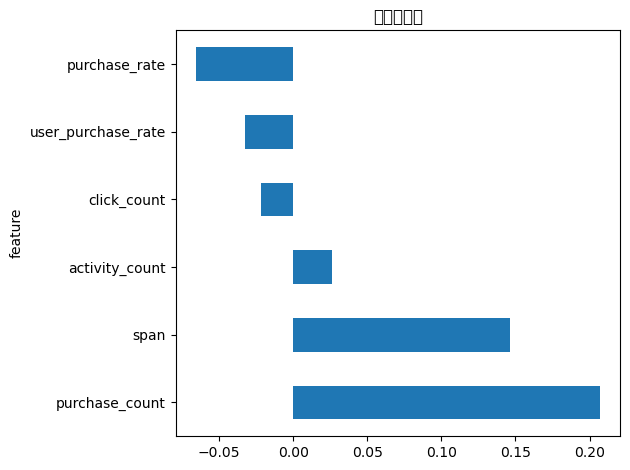

C:\Users\江楠\AppData\Local\Temp\ipykernel_4344\1940465407.py:13: UserWarning: Glyph 22797 (\N{CJK UNIFIED IDEOGRAPH-590D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\江楠\AppData\Local\Temp\ipykernel_4344\1940465407.py:13: UserWarning: Glyph 36141 (\N{CJK UNIFIED IDEOGRAPH-8D2D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\江楠\AppData\Local\Temp\ipykernel_4344\1940465407.py:13: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\江楠\AppData\Local\Temp\ipykernel_4344\1940465407.py:13: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\江楠\AppData\Local\Temp\ipykernel_4344\1940465407.py:13: UserWarning: Glyph 26410 (\N{CJK UNIFIED IDEOGRAPH-672A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\江楠\AppData\Local\Temp\ipykernel_4344\1940465407.py:14: UserWarning: Glyph 22797 (\N{CJK UNIFIED IDEOGRAPH-

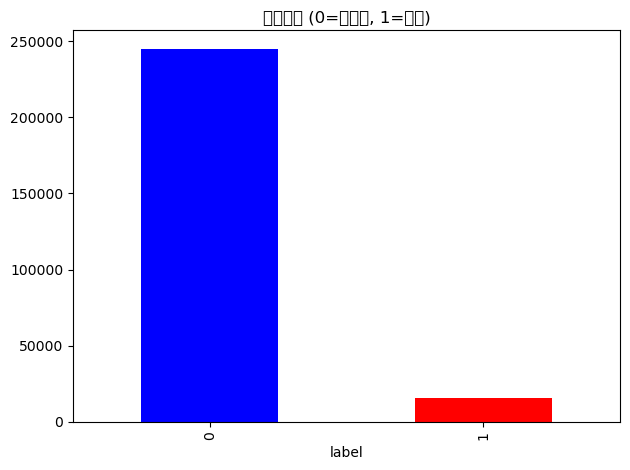

In [72]:
import matplotlib.pyplot as plt

# 图1：特征重要性
importance.plot(kind='barh', x='feature', y='weight', legend=False)
plt.title('特征重要性')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

# 图2：标签分布
train_valid['label'].value_counts().plot(kind='bar', color=['blue', 'red'])
plt.title('复购分布 (0=未复购, 1=复购)')
plt.tight_layout()
plt.savefig('label_distribution.png')
plt.show()